# Ocultação por Umbriel em 21-09-2020, observado por K. Getrost


### Vamos começar a redução importando os pacotes necessarios

In [1]:
import numpy as np
import pylab as pl
import astropy.units as u
from astropy.time import Time

from sora import __version__
print('Sora version:',__version__) # Fazer um print da versão do SORA para garantir que estamos usando a correta

from sora import Observer, Occultation, Star, LightCurve
from sora.extra import draw_ellipse, ChiSquare

Sora version: 0.1.1


### Primeiro passo é definir a nossa curva de luz. 
Estou usando como input a saída do PRAIA Photometry, modo 4 

In [2]:
lc = LightCurve(name='K.Getrost', 
                file = 'curve_Umbriel_2020-09-21_Getrost.dat', 
                #usecols = [3,9,10], #Lembrete, Python começa na coluna 0 !!!!
                usecols = [0,1,2], #Lembrete, Python começa na coluna 0 !!!!
                exptime = 0.4996573)

In [3]:
print(lc)

Light curve name: K.Getrost
Initial time: 2020-09-21 08:20:01.822 UTC
End time:     2020-09-21 08:25:04.169 UTC
Duration:     5.039 minutes
Time offset:  0.000 seconds

Exposure time:    0.4997 seconds
Cycle time:       0.5003 seconds
Num. data points: 598


There is no occultation associated with this light curve.

Object LightCurve model was not fitted.

Immersion and emersion times were not fitted or instantiated.




### Após, definimos os parâmetros do modelo:
- Distância ao objeto ocultador (AU);
- Diametro estelar à distancia do objeto (km);
- Modulo da velocidade tangente a superficie (km/s);

**Obs.:** Em primeiro momento utilizamos a velocidade nominal do evento, porém após a redução completa e termos a forma do objeto bem definida, devemos calcular a velocidade normal à superfície do corpo e refazer o ajuste das curvas de luz com a velocidade corrigida. Isso é extremamente necessário em casos onde a escala de Fresnel domina a curva de luz ou em casos de cordas extremamente razantes. Para 90% dos casos o efeito é pequeno e isso não afeta a redução da curva de luz.

In [4]:
lc.set_dist(19.019454*u.AU)
lc.set_vel(17.12)
lc.set_star_diam(0.3387501*u.km)

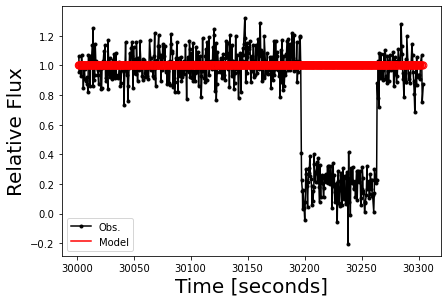

In [5]:
lc.plot_lc()

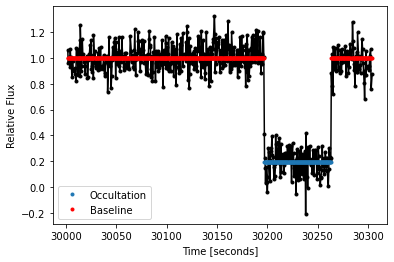

In [6]:
preliminar = lc.occ_detect(plot=True)
pl.show()

In [7]:
print('VALORES PRELIMINARES')
print('Fluxo fora do evento:  ',preliminar['baseline'])
print('Fluxo dentro do evento:',preliminar['baseline']- preliminar['depth'])
print('\n')
print('Tempo de imersão:      ',preliminar['immersion_time'])
print('Tempo de emersão:      ',preliminar['emersion_time'])
print('Tempo central:         ',preliminar['central_time'])
print('Duração:               ',preliminar['occultation_duration'])
print('\n')
print('Numero de pontos dentro do evento:',len(lc.flux[preliminar['occ_mask']]))

VALORES PRELIMINARES
Fluxo fora do evento:   1.0009123207276345
Fluxo dentro do evento: 0.19488037321300755


Tempo de imersão:       30196.847874373198
Tempo de emersão:       30263.132165819407
Tempo central:          30229.990020096302
Duração:                66.28429144620895


Numero de pontos dentro do evento: 133


Chamamos este ajuste de preliminar uma vez que não estamos considerando todos os efeitos na curva de luz (difração, tamanho da estrela e tempo de exposição), porém no que diz respeito ao fluxo dentro e fora do evento esses valores são robustos. É importante ressaltar que isso é verdade uma vez que temos um número adequado de pontos, como é o caso da ocultação por Umbriel. Além disso podemos fazer esse ajuste separado uma vez que os valores de fluxo possuem uma baixa correlação com os tempos de imersão e emersão.

### Os parâmetros que devemos controlar são:
- `tmin`: Tempo de inicio dos dados que serão considerados no ajuste;
- `tmax`: Tempo final dos dados que serão considerados no ajuste;
- `flux_max`: Fluxo fora do evento, padrão igual a 1.0;
- `flux_min`: Fluxo dentro do evento, padrão igual a 0.0;

### Os parâmetros que iremos ajustar são:
- `immersion_time`: Chute inicial para o tempo de imersão;
- `emersion_time`: Chute inicial para o tempo de emersão;
- `delta_t`: Região de busca para o ajuste;



Uma das maiores qualidades do python e de um jupyter-notebook (na minha opinião) é ter a visualização do processo inteiro. Então antes de fazermos o ajuste vamos visualizar o que (de fato) vamos fazer no ajuste.


In [20]:
tmin = 30230 - 60 # escolha arbitraria, eu gosto de utilizar, uma duração a menos do que o tempo central
tmax = 30230 + 60 # igual o de cima, porém com uma duração a mais do que o tempo central

flux_max = 1.00091
flux_min = 0.19488

immersion_time = 30196.84 # Vamos usar como chute inicial os valores que sairam do ajuste preliminar
emersion_time  = 30263.13  #

delta_t = 2.0000 # considerando o tempo de ciclo procurar em torno de 10 pontos. 

O que esses números significam ?

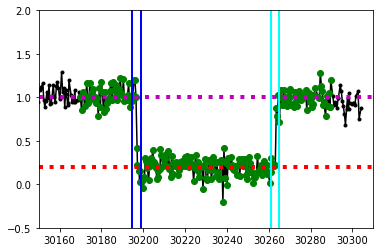

In [21]:
mask = (lc.time > tmin)*(lc.time < tmax)

pl.plot(lc.time,lc.flux,'k.-')
pl.plot(lc.time[mask],lc.flux[mask],'go')
pl.axhline(flux_min, color='r', linestyle='dotted', linewidth=4)
pl.axhline(flux_max, color='m', linestyle='dotted', linewidth=4)
pl.axvline(immersion_time - delta_t, color='blue', linestyle='-', linewidth=2)
pl.axvline(immersion_time + delta_t, color='blue', linestyle='-', linewidth=2)

pl.axvline(emersion_time - delta_t, color='cyan', linestyle='-', linewidth=2)
pl.axvline(emersion_time + delta_t, color='cyan', linestyle='-', linewidth=2)


pl.xlim(tmin-20, tmax+20)
pl.ylim(-0.5, 2.0)
pl.show()

**Você estará usando os pontos em verde para fazer o ajuste, o seu fluxo modelado irá da linha magenta (fluxo fora do evento) até a linha vermelha (fluxo dentro do evento). Você irá testar valores de tempo de imersão entre as linhas azuis e para o tempo de emersão entre as linhas cianas.**

Aqui eu recomendo fortemente você sempre fazer o plot acima antes de fazer o ajuste, isso te permitirá não fazer nada as cegas e entender exatamente o que o código está fazendo.

In [22]:
### No meu computador pessoal esse ajuste demorou: ~20 segundos

chi2 = lc.occ_lcfit(tmin=tmin,
                    tmax=tmax,
                    immersion_time =immersion_time,
                    emersion_time = emersion_time,
                    delta_t = delta_t,
                    flux_min= flux_min,
                    flux_max = flux_max,
                    loop=1000)

Minimum chi-square: 228.140
Number of fitted points: 239
Number of fitted parameters: 2
Minimum chi-square per degree of freedom: 0.963

immersion:
    1-sigma: 30196.955 +/- 0.062
    3-sigma: 30196.891 +/- 0.222

emersion:
    1-sigma: 30263.451 +/- 0.060
    3-sigma: 30263.460 +/- 0.170



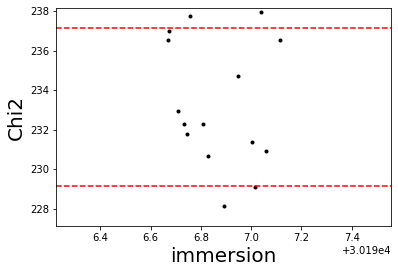

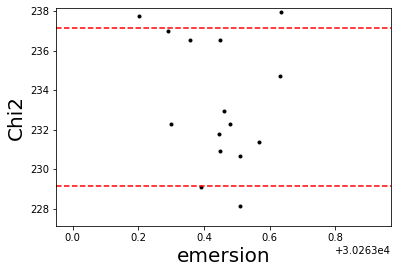

In [23]:
print(chi2)
chi2.plot_chi2()

É evidente que o número de loops não foi adequado. Para resolver isso podemos simplesmente aumentar o número de loops e esperar terminar, ou re-avaliar os parâmetros de entrada, baseado-se nos resultados deste primeiro ajuste. 

Recomendo utilizar os valores de 3-sigma como base.

In [24]:
immersion_time = 30196.891 # Agora aqui vamos usar os valores obtidos para o 3-sigma
emersion_time = 30263.460  # Nota importante, esses numeros irão variar ligeiramente a cada rodada

delta_t = 0.4000 # Como a incerteza de 3-sigma é ~0.6, podemos usar algo perto do dobro aqui 

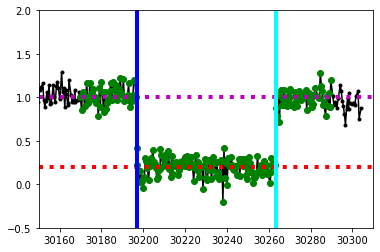

In [25]:
mask = (lc.time > tmin)*(lc.time < tmax)

pl.plot(lc.time,lc.flux,'k.-')
pl.plot(lc.time[mask],lc.flux[mask],'go')
pl.axhline(flux_min, color='r', linestyle='dotted', linewidth=4)
pl.axhline(flux_max, color='m', linestyle='dotted', linewidth=4)
pl.axvline(immersion_time - delta_t, color='blue', linestyle='-', linewidth=2)
pl.axvline(immersion_time + delta_t, color='blue', linestyle='-', linewidth=2)

pl.axvline(emersion_time - delta_t, color='cyan', linestyle='-', linewidth=2)
pl.axvline(emersion_time + delta_t, color='cyan', linestyle='-', linewidth=2)


pl.xlim(tmin-20, tmax+20)
pl.ylim(-0.5, 2.0)
pl.show()

In [26]:
### No meu computador pessoal esse ajuste demorou: ~197 segundos
chi2 = lc.occ_lcfit(tmin=tmin,
                    tmax=tmax,
                    immersion_time =immersion_time,
                    emersion_time = emersion_time,
                    delta_t = delta_t,
                    flux_min= flux_min,
                    flux_max = flux_max,
                    loop=10000) #Agora com um loop maior


Minimum chi-square: 226.683
Number of fitted points: 239
Number of fitted parameters: 2
Minimum chi-square per degree of freedom: 0.956

immersion:
    1-sigma: 30196.934 +/- 0.062
    3-sigma: 30196.884 +/- 0.221

emersion:
    1-sigma: 30263.439 +/- 0.064
    3-sigma: 30263.404 +/- 0.233



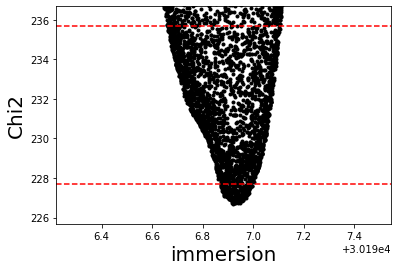

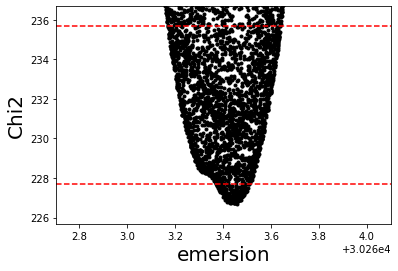

In [27]:
print(chi2)
chi2.plot_chi2()

Agora temos uma curva de chi-quadrado adequada.

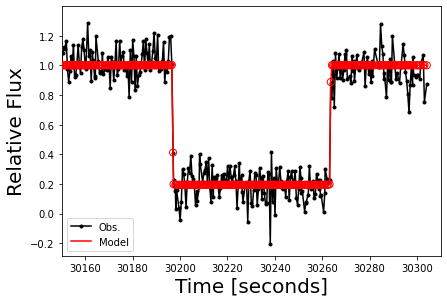

In [28]:
lc.plot_lc()
pl.xlim(tmin-20,tmax+20)
pl.show()

### Esse é o ajuste que deve ser considerado e levado para a proxima etapa. 

**Obs.:** Lembrando que após o ajuste da elipse preliminar devemos obter o valor da velocidade normal à superfície do corpo, que irá ser diferente (menor) do que a velocidade nominal para cordas não equatoriais. Esse valor deverá ser utilizado aqui no lugar do valor nominal de 17.12 km.  

In [29]:
print(lc)

Light curve name: K.Getrost
Initial time: 2020-09-21 08:20:01.822 UTC
End time:     2020-09-21 08:25:04.169 UTC
Duration:     5.039 minutes
Time offset:  0.000 seconds

Exposure time:    0.4997 seconds
Cycle time:       0.5003 seconds
Num. data points: 598

Bandpass:            0.700 +/- 0.300 microns
Used shadow velocity: 17.120 km/s
Fresnel scale:        0.058 seconds or 0.99 km
Stellar size effect:  0.020 seconds or 0.34 km
Inst. response:       0.500 seconds or 8.55 km
Dead time effect:     0.001 seconds or 0.01 km
Model resolution:     0.006 seconds or 0.10 km
Modelled baseflux:    1.001
Modelled bottomflux:  0.195
Light curve sigma:    0.105

Immersion time: 2020-09-21 08:23:16.934 UTC +/- 0.062 seconds
Emersion time:  2020-09-21 08:24:23.439 UTC +/- 0.064 seconds

Monte Carlo chi square fit.

Minimum chi-square: 226.683
Number of fitted points: 239
Number of fitted parameters: 2
Minimum chi-square per degree of freedom: 0.956

immersion:
    1-sigma: 30196.934 +/- 0.062
    3-si

***